<hr>


<span style="font-size:32px"><b>Apprentice Chef - Revenue Prediction Modeling</b></span><br><br>
<br>
<span style="font-size:28px"><b>Supervised Machine Learning </b></span><br>
<br>
<span style="font-size:18px">Jiehui Lin, MSBA</span><br>
<br>
<span style="font-size:18px">[GitHub](https://github.com/JiehuiL906)</span><br>
<br>
<span style= "font-size:18px">Hult International Business School <span><br>

    
    
<hr>
<hr>


<b>Objective:</b>
<ul>
<li>Examine what are critical factors affect revenue generated for the meals delivery company Apprentice Chef </li>
<li>Build machine learning model to predict revenue over first year of each customer's life cycle</li>
</ul>

<b>Presumption:</b>
<ul>
<li> 90% of revenue comes from customers that have been ordered meals 12 months or less</li>
<li> A cleaned data set of approx 2000 customers is statistically sound and representative </li>
</ul>    

<h4><b>Data Loading and Verifying </h4><b>

In [1]:
# importing libraries
import pandas as pd             # data science essentials
import matplotlib.pyplot as plt # essential graphical output
import seaborn as sns           # enhanced graphical output
import statsmodels.formula.api as smf # regression modeling
from sklearn.model_selection import train_test_split # train/test split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor

# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


original_df='Apprentice_Chef_Dataset.xlsx'
chef = pd.read_excel(original_df)

chef.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   REVENUE                       1946 non-null   float64
 1   CROSS_SELL_SUCCESS            1946 non-null   int64  
 2   NAME                          1946 non-null   object 
 3   EMAIL                         1946 non-null   object 
 4   FIRST_NAME                    1946 non-null   object 
 5   FAMILY_NAME                   1899 non-null   object 
 6   TOTAL_MEALS_ORDERED           1946 non-null   int64  
 7   UNIQUE_MEALS_PURCH            1946 non-null   int64  
 8   CONTACTS_W_CUSTOMER_SERVICE   1946 non-null   int64  
 9   PRODUCT_CATEGORIES_VIEWED     1946 non-null   int64  
 10  AVG_TIME_PER_SITE_VISIT       1946 non-null   float64
 11  MOBILE_NUMBER                 1946 non-null   int64  
 12  CANCELLATIONS_BEFORE_NOON     1946 non-null   int64  
 13  CAN

In [2]:
# checking missing value 
mv_df = (chef.isna()
            .sum()
            .to_frame('missing_value_count')
            .assign(missing_value_ratio = lambda x: x['missing_value_count']/len(chef))
            .loc[chef.isna().any()] )
print(mv_df)

             missing_value_count  missing_value_ratio
FAMILY_NAME                   47             0.024152


no effect on further analysis with missing value of family names 

<h4><b>Data Visualizing and Feature Engineering </h4><b>
    <h5> Numerical Variables </h5>

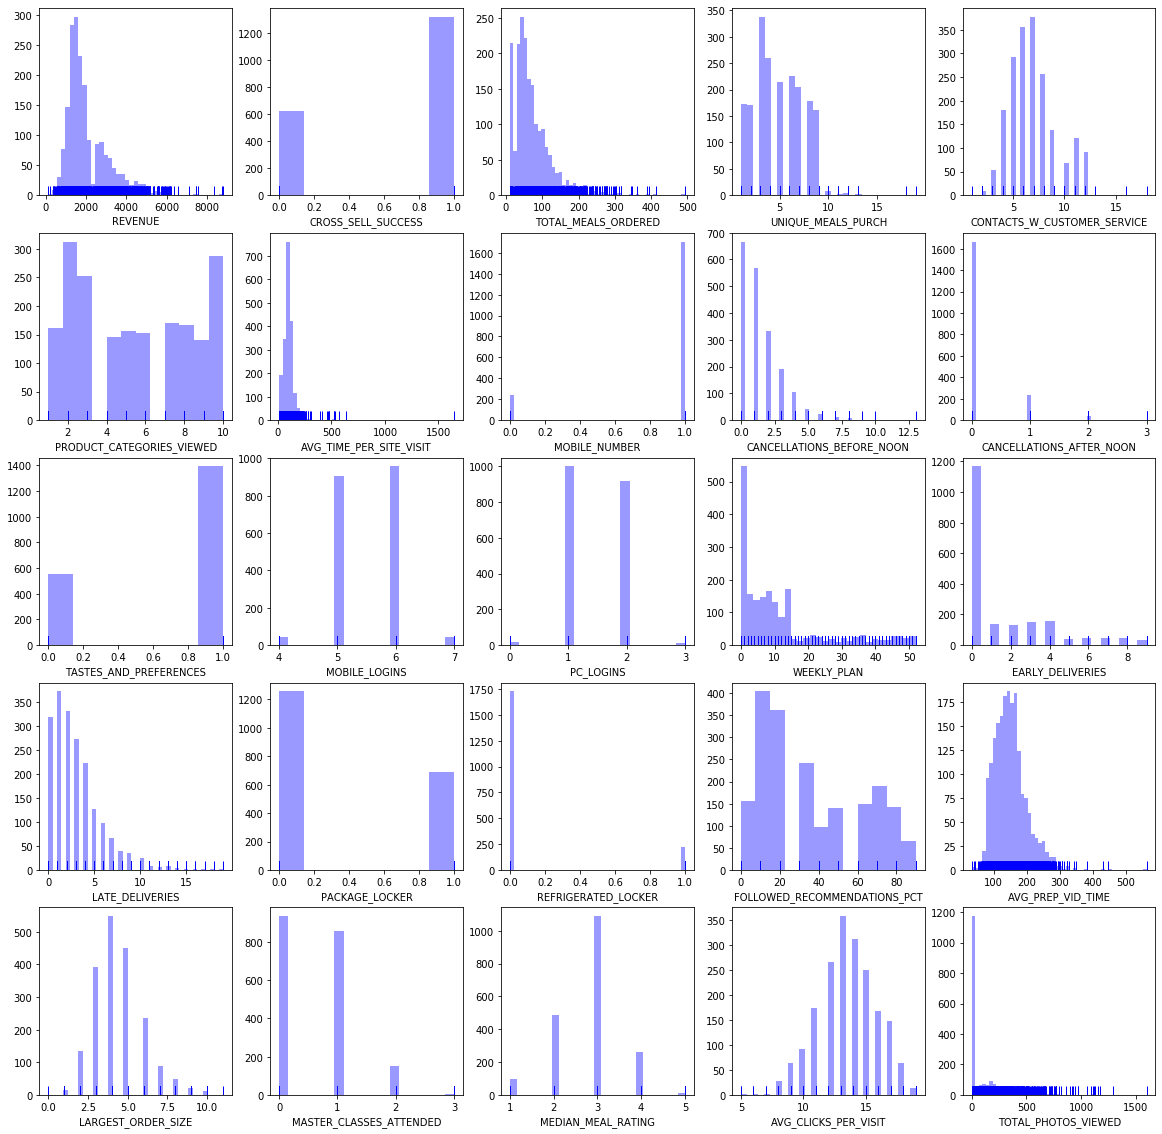

In [3]:
# subset numerical variables 
chef_num = chef.drop(['NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME'], axis=1)

# create a loop to pull histograms to visulaize each numeriable variable 
f, axes = plt.subplots(5, 5, figsize=(20, 20), sharex=False)
for ax, feature in zip(axes.flat, chef_num.columns):
    sns.distplot(chef[feature], color="blue", kde=False, rug=True, ax=ax)

From initial visualization of histograms, 
<ul>
<li>for some continuous variables such as TOTAL_MEALS_ORDERS, AVG_TIME_PER_SITE_VISIT, AVG_PREP_VID_TIME are highly skewed to right, logarithm transformation might get better summary of distribution</li>
<li>for some discrete variables closer to normal distribution such as CONTACT_WITH_CUSTOMERS_SERVICE,LARGEST_ORDER_SIZE, check the outliers both side which might have impact on revenue </li>
<li>for some discrete variables right skewed such as UNIQUE_MEALS_PURCH, LATER_DELIVERIES, check the outliers high end side which might have impact on revenue </li>    
<li> for binary variables such as CROSS_SELL_SUCCESS, PACKAGE_LOCKER, keep as it to further assess</li>
<li> for multimodal such as PRODUCT_CATEGORIES_VIEWED, FOLLOWED_RECOMMENDATIONS_PCT, different segments might affect revenue varying 
<ul>
<br>

Next step is to set up outliers thresholds to exam correlation

In [4]:
# cross checking quantile interval (0.025 - 0.975)
chef_num.quantile([0.025, 0.975])

,REVENUE,CROSS_SELL_SUCCESS,TOTAL_MEALS_ORDERED,UNIQUE_MEALS_PURCH,CONTACTS_W_CUSTOMER_SERVICE,PRODUCT_CATEGORIES_VIEWED,AVG_TIME_PER_SITE_VISIT,MOBILE_NUMBER,CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON,TASTES_AND_PREFERENCES,MOBILE_LOGINS,PC_LOGINS,WEEKLY_PLAN,EARLY_DELIVERIES,LATE_DELIVERIES,PACKAGE_LOCKER,REFRIGERATED_LOCKER,FOLLOWED_RECOMMENDATIONS_PCT,AVG_PREP_VID_TIME,LARGEST_ORDER_SIZE,MASTER_CLASSES_ATTENDED,MEDIAN_MEAL_RATING,AVG_CLICKS_PER_VISIT,TOTAL_PHOTOS_VIEWED
0.025,790.00,0.0,13.00,1.0,3.0,1.0,29.00000,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,79.1250,2.0,0.0,1.0,9.0,0.000
0.975,5006.75,1.0,221.75,9.0,12.0,10.0,212.23875,1.0,5.0,1.0,1.0,6.0,2.0,49.0,8.0,10.0,1.0,1.0,90.0,264.9375,8.0,2.0,4.0,18.0,608.125


In [5]:
# setting outlier thresholds
avg_time_pvisit_hi  = 212.2
avg_prep_vid_time_hi = 264.94
avg_prep_vid_time_lo = 79.13
avg_cli_pvisit_hi  = 18
avg_cli_pvisit_lo  = 9
tot_meals_ord_hi = 221.75
unique_meals_pur_hi = 9
contact_w_CS_hi = 12
contact_w_CS_lo = 3
cancel_b_noon_hi = 5
cancel_a_noon_hi = 1
mobile_log_hi = 6
mobile_log_lo = 5
pc_log_hi = 2
pc_log_lo = 1
weekly_plan_hi = 49
early_d_hi = 8
late_d_hi = 10
tot_photo_v_hi = 608.13
lar_ord_size_hi = 8
lar_ord_size_lo = 2
mas_class_att_hi = 2
med_meal_rat_hi =  4

In [6]:
# developing features (columns) for outliers
chef['out_avg_time_pvisit'] = np.where(chef['AVG_TIME_PER_SITE_VISIT']>avg_time_pvisit_hi, 1, 0)
chef['out_avg_prep_video'] = np.where((chef['AVG_PREP_VID_TIME']>avg_prep_vid_time_hi)|(chef['AVG_PREP_VID_TIME']<avg_prep_vid_time_lo), 1, 0 )
chef['out_avg_clicks_pvisit'] = np.where((chef['AVG_CLICKS_PER_VISIT']>avg_cli_pvisit_hi)|(chef['AVG_CLICKS_PER_VISIT']<avg_cli_pvisit_lo), 1, 0 )
chef['out_tot_meals'] = np.where(chef['TOTAL_MEALS_ORDERED']>tot_meals_ord_hi,1, 0 )
chef['out_uni_meals'] = np.where(chef['UNIQUE_MEALS_PURCH']>unique_meals_pur_hi, 1, 0 )
chef['out_contact_CS'] = np.where((chef['CONTACTS_W_CUSTOMER_SERVICE']>contact_w_CS_hi)|(chef['CONTACTS_W_CUSTOMER_SERVICE']<contact_w_CS_lo), 1, 0 )
chef['out_cancel_bnoon'] = np.where(chef['CANCELLATIONS_BEFORE_NOON']>cancel_b_noon_hi, 1, 0 )
chef['out_cancel_anoon'] = np.where(chef['CANCELLATIONS_AFTER_NOON']>cancel_a_noon_hi, 1, 0 )
chef['out_mobile_log'] = np.where((chef['MOBILE_LOGINS']>mobile_log_hi)|(chef['MOBILE_LOGINS']<mobile_log_lo), 1, 0 )
chef['out_pc_log'] = np.where((chef['PC_LOGINS']>pc_log_hi)|(chef['PC_LOGINS']<pc_log_lo), 1, 0 )
chef['out_weekly_plan'] = np.where(chef['WEEKLY_PLAN']>weekly_plan_hi, 1, 0 )
chef['out_early_d'] = np.where(chef['EARLY_DELIVERIES']>early_d_hi, 1, 0 )
chef['out_late_d'] = np.where(chef['LATE_DELIVERIES']>late_d_hi, 1, 0 )
chef['out_tot_photo'] = np.where(chef['TOTAL_PHOTOS_VIEWED']>tot_photo_v_hi, 1, 0 )
chef['out_lar_order'] = np.where((chef['LARGEST_ORDER_SIZE']>lar_ord_size_hi)|(chef['LARGEST_ORDER_SIZE']<lar_ord_size_lo), 1, 0 )
chef['out_master_class'] = np.where(chef['MASTER_CLASSES_ATTENDED']>mas_class_att_hi, 1, 0 )
chef['out_meals_rating'] = np.where(chef['MEDIAN_MEAL_RATING']>med_meal_rat_hi, 1, 0 )

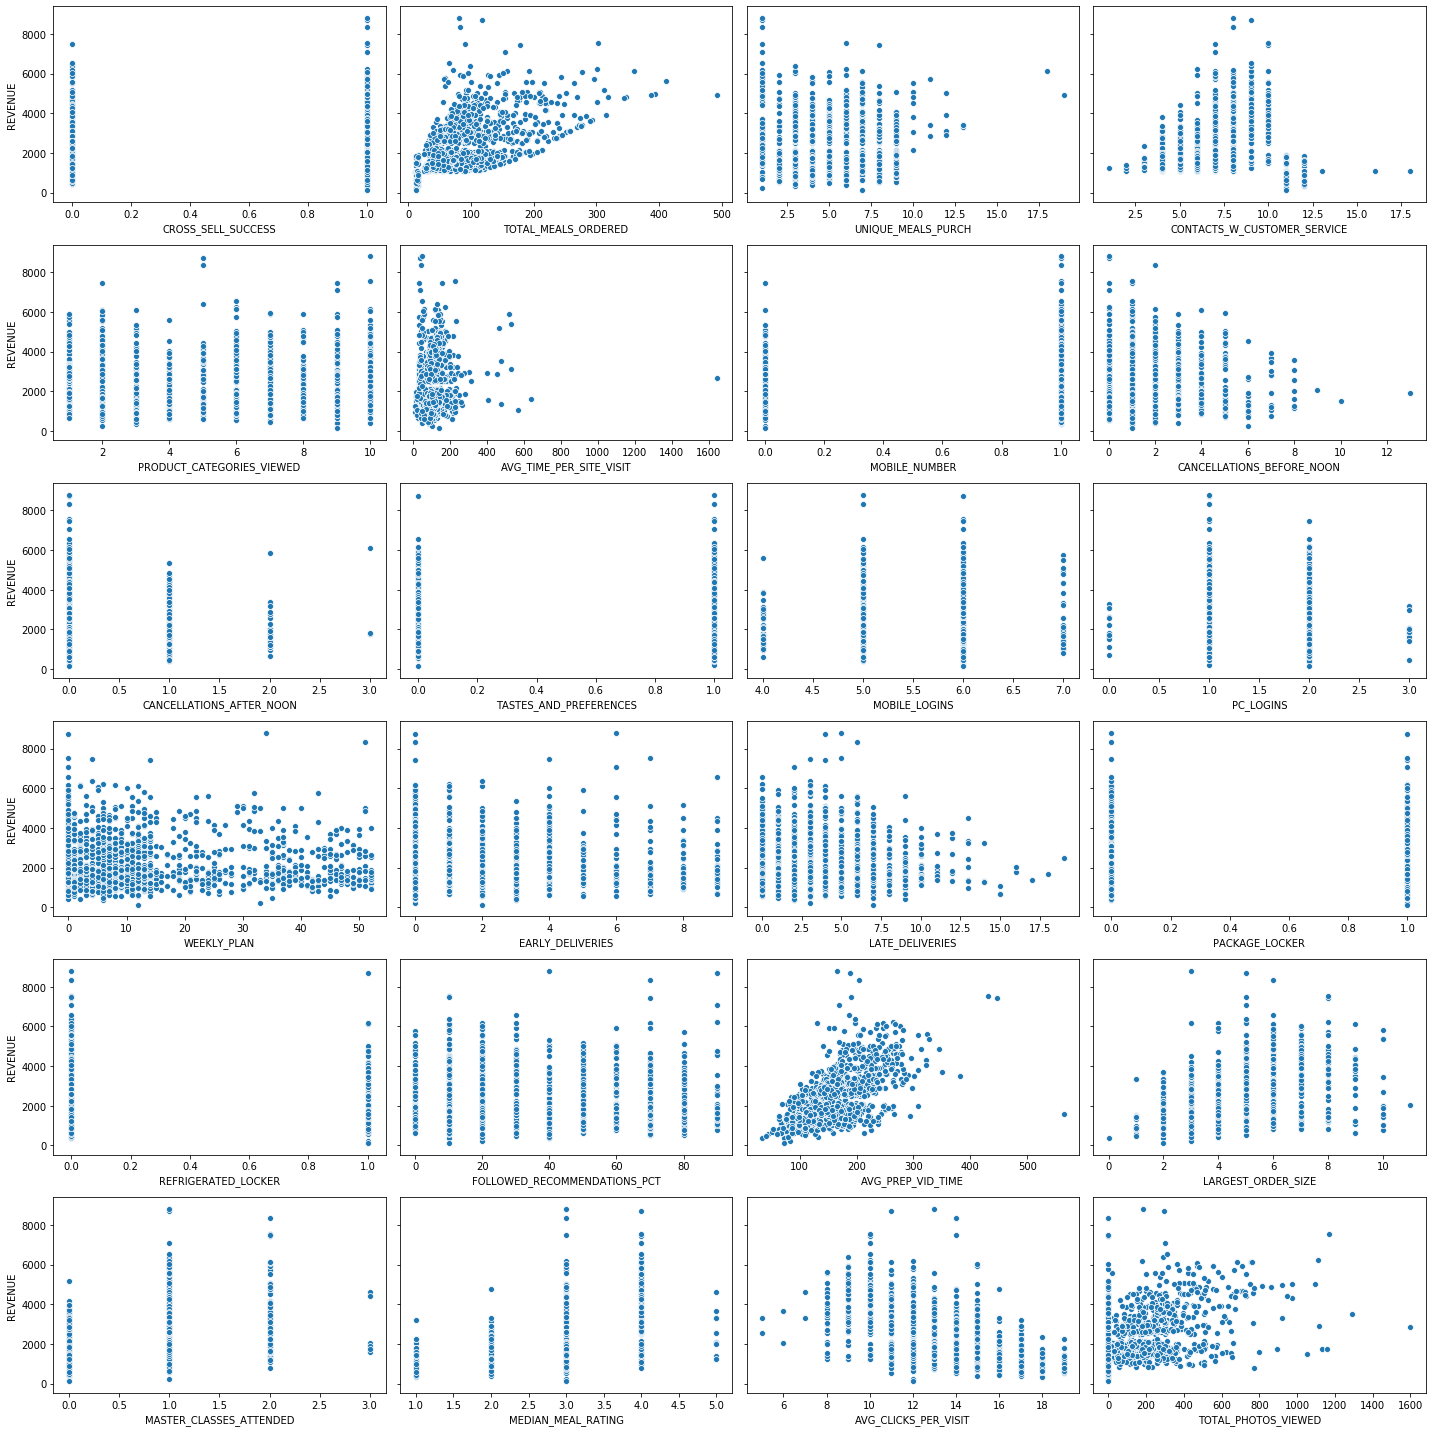

In [7]:
# create loop to pull scatterplots to check association between each explanatory variables and response variable REVENUE 

f, axes = plt.subplots(6, 4, figsize=(20, 20),sharex=False, sharey=True, squeeze=False)
for ax,col in zip(axes.flat, chef_num.columns[1:]):
    sns.scatterplot(x=chef_num[col], y=chef_num['REVENUE'], ax=ax)
    plt.tight_layout()


from visualization of scatter plots 
<ul>
<li> explanatory variables TOTAL_MEALS_ORDERED, AVG_PREP_VID_TIME, MEDIAN_MEAL_RATING, TOTAL_PHOTO_VIEWED has positive association with REVENUE</li>
<li> those variables CONTACTS_W_CUSTOMER_SERVICE,LARGEST_ORDER_SIZE, MASTER_CLASSES_ATTENDED, AVG_CLICKS_PER_VISIT have initially positive related to REVENUE but reverse trend at some turning points</li>
<li> some variables AVG_TIME_PER_SITE_VISIT, CANCELLATIONS_BEFORE_NOON,CANCELLATIONS_AFTER_NOON LATE_DELIVERIES, are shown negative correlation with REVENUE</li>
<li> most binary variables display NO obvious association</li>
<li> some discrete variables PRODUCT_CATEGORIES_VIEWED, FOLLOWED_RECOMMENDATIONS_PCT display NO obvious association, either</li>
</ul> 
<br>

Based on the trend-changing observed above, I am going to develop threshold which capture information to improve prediction


In [8]:
# refine threshold 
avg_time_pvisit_change_hi  = 300
avg_prep_vid_time_change_hi = 300
tot_meals_ord_change_hi = 250
contact_cs_change_hi = 10

unique_mpurch_change_at = 1
cancel_b_noon_change_at = 0
cancel_a_noon_change_at = 0
weekly_plan_change_at = 0
early_d_change_at = 0
later_d_change_at = 0
tot_photo_v_change_at = 0
mas_class_att_change_at_1 = 1
mas_class_att_change_at_2 = 2
med_meal_rat_change_at_3 =  3
med_meal_rat_change_at_4 =  4

In [9]:
# making changing at threshold
chef['change_ave_time_pvisit'] = np.where(chef['AVG_TIME_PER_SITE_VISIT']>avg_time_pvisit_change_hi, 1, 0 )
chef['change_ave_prep_vid'] = np.where(chef['AVG_PREP_VID_TIME']>avg_prep_vid_time_change_hi, 1, 0 )
chef['change_tot_meals_ord'] = np.where(chef['TOTAL_MEALS_ORDERED']>tot_meals_ord_change_hi, 1, 0 )
chef['change_contact_cs'] = np.where(chef['CONTACTS_W_CUSTOMER_SERVICE']>contact_cs_change_hi, 1, 0 )


chef['change_unique_meals'] = np.where(chef['UNIQUE_MEALS_PURCH']==unique_mpurch_change_at, 1, 0 )
chef['change_cancel_bnoon'] = np.where(chef['CANCELLATIONS_BEFORE_NOON']==cancel_b_noon_change_at, 1, 0 )
chef['change_cancel_anoon'] = np.where(chef['CANCELLATIONS_AFTER_NOON']==cancel_a_noon_change_at, 1, 0 )
chef['change_week_plan'] = np.where(chef['WEEKLY_PLAN']==weekly_plan_change_at, 1, 0 )
chef['change_early_d'] = np.where(chef['EARLY_DELIVERIES']==early_d_change_at, 1, 0 )
chef['change_late_d'] = np.where(chef['LATE_DELIVERIES']==later_d_change_at, 1, 0 )
chef['change_tot_photov'] = np.where(chef['TOTAL_PHOTOS_VIEWED']==tot_photo_v_change_at, 1, 0 )
chef['change_mas_class'] = np.where((chef['MASTER_CLASSES_ATTENDED']==mas_class_att_change_at_1)|(chef['MASTER_CLASSES_ATTENDED']==mas_class_att_change_at_2), 1, 0 )
chef['change_med_mealr'] = np.where((chef['MEDIAN_MEAL_RATING']==med_meal_rat_change_at_3)|(chef['MEDIAN_MEAL_RATING']==med_meal_rat_change_at_4), 1, 0 )

In [10]:
# create new log variable for average time per site visit which is highly skew
chef['log_avg_tps_visit'] = np.log(chef['AVG_TIME_PER_SITE_VISIT'])
chef['log_tot_mealsor'] = np.log(chef['TOTAL_MEALS_ORDERED'])
chef['log_avg_pvid_time'] = np.log(chef['AVG_PREP_VID_TIME'])

 <h5> Categorical Variables </h5>
 <br>
 
 Since marketing team claimed customers' email domain somewhat related to response rate, I'd like to examine whether three e-mail domain groups (professional, personal, junk) are associated to revenue 

In [12]:
# handling email domains

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef.iterrows():
    
    # splitting email domain at '@'
    split_email = chef.loc[index, 'EMAIL'].split(sep = '@')
    
    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)
    

# converting placeholder_lst into a DataFrame 
email_df = pd.DataFrame(placeholder_lst)



In [13]:
# renaming column to concatenate
email_df.columns= ['id', 'email_domain']


# concatenating personal_email_domain with chef DataFrame
chef = pd.concat([chef, email_df.loc[:, 'email_domain']],axis =1)


In [14]:
# email domain types
professional_email_domains = [ '@jnj.com',  '@ibm.com',
       '@goldmansacs.com', '@homedepot.com','@caterpillar.com',
         '@verizon.com', '@merck.com', '@unitedtech.com', '@nike.com',
       '@unitedhealth.com', '@mcdonalds.com', '@pg.com', '@mmm.com',
       '@apple.com', '@cisco.com', '@travelers.com', '@cocacola.com',
       '@jpmorgan.com', '@chevron.com', '@amex.com', '@dupont.com',
       '@boeing.com', '@exxon.com', '@intel.com', '@ge.org', '@disney.com',
       '@microsoft.com', '@pfizer.com', '@visa.com', '@walmart.com']
personal_email_domains  = ['@gmail.com', '@yahoo.com', '@protonmail.com']
junk_email_domains = ['@me.com', '@aol.com', '@hotmail.com', '@live.com', '@msn.com','@passport.com']

# placeholder list
placeholder_lst2 = []


# looping to group observations by domain type
for domain in chef['email_domain']:
        if '@' + domain in professional_email_domains:
            placeholder_lst2.append('professional')
            
        elif '@' + domain in personal_email_domains:
            placeholder_lst2.append('personal')
            
        elif '@' + domain in junk_email_domains:
            placeholder_lst2.append('junk')
                        
        else:
            print('Unknown')


# concatenating with original DataFrame
chef['domain_group'] = pd.Series(placeholder_lst2)


# checking results
chef['domain_group'].value_counts()

personal        861
professional    696
junk            389
Name: domain_group, dtype: int64

In [15]:
# one hot encoding categorical variables
one_hot_domain       = pd.get_dummies(chef['domain_group'])


# dropping categorical variables after they've been encoded
chef = chef.drop('domain_group', axis = 1)

# joining codings together
chef = chef.join([one_hot_domain])

<h4><b> Initiate Linear Regression Full Modeling </h4><b>

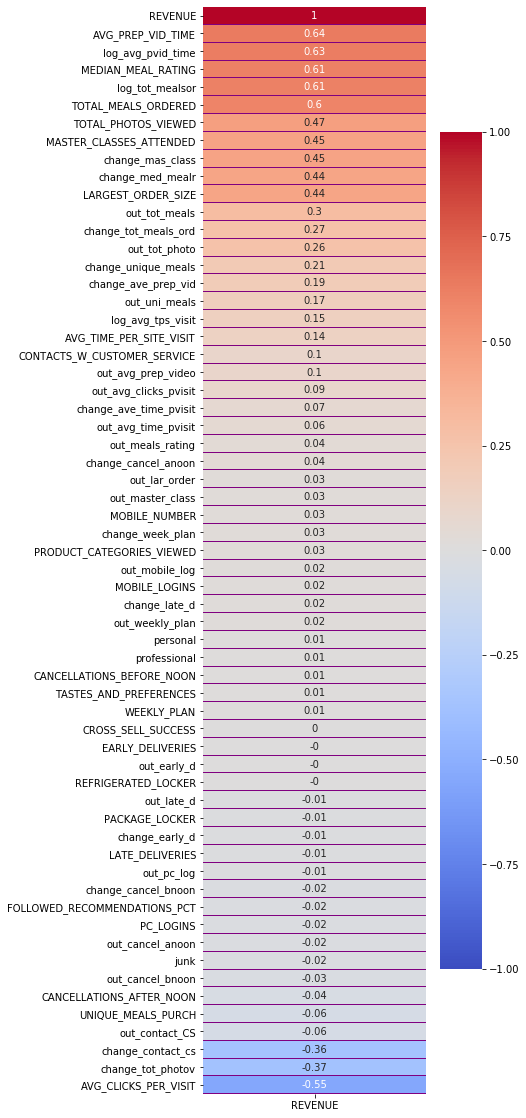

In [17]:
# creating a (Pearson) correlation matrix
chef_corr = chef.corr().round(2)

plt.figure(figsize=(5,20))

# printing (Pearson) correlations with Revenue
sns.heatmap(chef_corr[['REVENUE']].sort_values(by=['REVENUE'],ascending=False),
            cmap='coolwarm', vmin=-1, vmax=1,linecolor='purple',linewidths=0.01,
            annot=True)

In [18]:
# saving feature-rich dataset in Excel
chef.to_excel('chef_feature_rich.xlsx',
                 index = False)

In [19]:
# making a copy of chef
chef_explanatory = chef.copy()

# dropping Revenue and categories variables from the explanatory variable set
chef_explanatory = chef.drop(['REVENUE', 'NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME', 'email_domain'], axis = 1)


In [20]:
# building a full model

# blueprinting a model type
lm_full = smf.ols(formula = """ chef['REVENUE'] ~ chef['CROSS_SELL_SUCCESS'] +
                                    chef['TOTAL_MEALS_ORDERED'] +
                                    chef['UNIQUE_MEALS_PURCH'] +
                                    chef['CONTACTS_W_CUSTOMER_SERVICE'] +
                                    chef['PRODUCT_CATEGORIES_VIEWED'] +
                                    chef['AVG_TIME_PER_SITE_VISIT'] +
                                    chef['MOBILE_NUMBER'] +
                                    chef['CANCELLATIONS_BEFORE_NOON'] +
                                    chef['CANCELLATIONS_AFTER_NOON'] +
                                    chef['TASTES_AND_PREFERENCES'] +
                                    chef['MOBILE_LOGINS'] +
                                    chef['PC_LOGINS'] +
                                    chef['WEEKLY_PLAN'] +
                                    chef['EARLY_DELIVERIES'] +
                                    chef['LATE_DELIVERIES'] +
                                    chef['PACKAGE_LOCKER'] +
                                    chef['REFRIGERATED_LOCKER'] +
                                    chef['FOLLOWED_RECOMMENDATIONS_PCT'] +
                                    chef['AVG_PREP_VID_TIME'] +
                                    chef['LARGEST_ORDER_SIZE'] +
                                    chef['MASTER_CLASSES_ATTENDED'] +
                                    chef['MEDIAN_MEAL_RATING'] +
                                    chef['AVG_CLICKS_PER_VISIT'] +
                                    chef['TOTAL_PHOTOS_VIEWED'] +
                                    chef['out_avg_time_pvisit'] +
                                    chef['out_avg_prep_video'] +
                                    chef['out_avg_clicks_pvisit'] +
                                    chef['out_tot_meals'] +
                                    chef['out_uni_meals'] +
                                    chef['out_contact_CS'] +
                                    chef['out_cancel_bnoon'] +
                                    chef['out_cancel_anoon'] +
                                    chef['out_mobile_log'] +
                                    chef['out_pc_log'] +
                                    chef['out_weekly_plan'] +
                                    chef['out_early_d'] +
                                    chef['out_late_d'] +
                                    chef['out_tot_photo'] +
                                    chef['out_lar_order'] +
                                    chef['out_master_class'] +
                                    chef['out_meals_rating'] +
                                    chef['change_ave_time_pvisit'] +
                                    chef['change_ave_prep_vid'] +
                                    chef['change_tot_meals_ord'] +
                                    chef['change_contact_cs'] +
                                    chef['change_unique_meals'] +
                                    chef['change_cancel_bnoon'] +
                                    chef['change_cancel_anoon'] +
                                    chef['change_week_plan'] +
                                    chef['change_early_d'] +
                                    chef['change_late_d'] +
                                    chef['change_tot_photov'] +
                                    chef['change_mas_class'] +
                                    chef['change_med_mealr'] +
                                    chef['log_avg_tps_visit'] +
                                    chef['log_tot_mealsor'] +
                                    chef['log_avg_pvid_time'] +
                                    chef['junk'] +
                                    chef['personal'] +
                                    chef['professional']""",
                                data = chef)


# telling Python to run the data through the blueprint
results_full = lm_full.fit()


# printing the results
results_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        chef['REVENUE']   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     101.9
Date:                Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:39:02   Log-Likelihood:                -15062.
No. Observations:                1946   AIC:                         3.024e+04
Df Residuals:                    1886   BIC:                         3.058e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             -279.5831    894.706     -0.312      0.755   -2034.301    1475.134
chef['CROSS_SELL_SUCCESS']             -85.1615     33.408     -2.549      0.011    -150.683     -19.640
chef['TOTAL_MEALS_ORDERED']              3.1234      1.108      2.819      0.005       0.951       5.296
chef['UNIQUE_MEALS_PURCH']               8.1014      6.258      1.295      0.196      -4.171      20.374
chef['CONTACTS_W_CUSTOMER_SERVICE']    128.5545      9.396     13.682      0.000     110.127     146.982
chef['PRODUCT_CATEGORIES_VIEWED']        7.0587      4.316      1.636      0.102      -1.405      15.523
chef['AVG_TIME_PER_SITE_VISIT']         -0.1008      0.479     -0.210      0.833      -1.041       0.839
chef['MOBILE_NUMBER']                   29.4324     39.933      0.737      0.461     -48.885     107.750
chef['CANCELLATIONS_BEFORE_NOON']       -5.8500     14.248     -0.411      0.681     -33.793      22.093
chef['CANCELLATIONS_AFTER_NOON']       231.9802    345.100      0.672      0.502    -444.838     908.799
chef['TASTES_AND_PREFERENCES']          19.7352     28.849      0.684      0.494     -36.844      76.314
chef['MOBILE_LOGINS']                   -2.5280     22.358     -0.113      0.910     -46.378      41.322
chef['PC_LOGINS']                      -26.2723     24.778     -1.060      0.289     -74.868      22.323
chef['WEEKLY_PLAN']                      0.1386      1.215      0.114      0.909      -2.244       2.521
chef['EARLY_DELIVERIES']                -6.8157     10.360     -0.658      0.511     -27.135      13.503
chef['LATE_DELIVERIES']                  7.1052      6.406      1.109      0.268      -5.459      19.669
chef['PACKAGE_LOCKER']                   1.6717     30.944      0.054      0.957     -59.016      62.360
chef['REFRIGERATED_LOCKER']            -55.6091     46.758     -1.189      0.234    -147.313      36.094
chef['FOLLOWED_RECOMMENDATIONS_PCT']     0.6895      0.555      1.243      0.214      -0.399       1.778
chef['AVG_PREP_VID_TIME']               11.7860      1.781      6.618      0.000       8.293      15.279
chef['LARGEST_ORDER_SIZE']             -75.3857     15.102     -4.992      0.000    -105.004     -45.767
chef['MASTER_CLASSES_ATTENDED']        171.2773     51.911      3.299      0.001      69.469     273.086
chef['MEDIAN_MEAL_RATING']             535.2786     45.651     11.725      0.000     445.747     624.810
chef['AVG_CLICKS_PER_VISIT']           -35.2113     10.986     -3.205      0.001     -56.757     -13.666
chef['TOTAL_PHOTOS_VIEWED']              0.4822      0.150      3.225      0.001       0.189       0.776
chef['out_avg_time_pvisit']            -26.1552    107.340     -0.244      0.808    -236.673     184.363
chef['out_avg_prep_video']            

Eliminate insignificant variables according to P-value 

<h4><b>Final Modeling Building </h4><b>
<h5> Import Package and Load Dataset</h5>

In [21]:
# specifying file name
file = 'chef_feature_rich.xlsx'

# reading the file into Python
chef = pd.read_excel(file)

I assume that the modeling will be more accurate when using logarithm transform of responsible variable REVENUE which is highly skewed

In [22]:
chef['log_revenue']= np.log(chef['REVENUE'])

<h5> Split Train and Test Sets</h5>

In [23]:
# preparing explanatory variable data
chef_data   = chef.drop(['REVENUE',
                         'log_revenue',
                         'NAME',
                         'EMAIL',
                         'FIRST_NAME',
                         'FAMILY_NAME',
                         'email_domain'],
                          axis = 1)


# preparing response variable data
chef_target = chef.loc[:, 'log_revenue']


# preparing training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
            chef_data,
            chef_target,
            test_size = 0.25,
            random_state = 222)


<h5> Identify Significant Variables to Build Liner Regression Modeling</h5>

In [26]:
x_variables = ['AVG_PREP_VID_TIME','MASTER_CLASSES_ATTENDED',
              'TOTAL_MEALS_ORDERED', 'LARGEST_ORDER_SIZE','CONTACTS_W_CUSTOMER_SERVICE',
               'change_tot_meals_ord',
               'TOTAL_PHOTOS_VIEWED', 'out_meals_rating','change_ave_prep_vid',
               'log_avg_tps_visit','out_master_class','change_med_mealr',
               'out_lar_order','change_contact_cs','change_unique_meals',
               'MEDIAN_MEAL_RATING']



In [27]:
# merging X_train and y_train so that they can be used in statsmodels
chef_train = pd.concat([X_train, y_train], axis = 1)


# Step 1: build a model
lm_best = smf.ols(formula =  """chef_train['log_revenue'] ~ 
                                chef_train['AVG_PREP_VID_TIME'] +
                                chef_train['MASTER_CLASSES_ATTENDED'] +
                                chef_train['TOTAL_MEALS_ORDERED'] +
                                chef_train['LARGEST_ORDER_SIZE'] +
                                chef_train['CONTACTS_W_CUSTOMER_SERVICE'] +
                                chef_train['change_tot_meals_ord'] +
                                chef_train['TOTAL_PHOTOS_VIEWED'] +
                                chef_train['out_meals_rating'] +
                                chef_train['change_ave_prep_vid'] +
                                chef_train['log_avg_tps_visit'] +
                                chef_train['out_master_class'] +
                                chef_train['change_med_mealr'] +
                                chef_train['out_lar_order'] +
                                chef_train['change_contact_cs'] +
                                chef_train['change_unique_meals'] +
                                chef_train['MEDIAN_MEAL_RATING']""",
                                data = chef_train)  


# Step 2: fit the model based on the data
results = lm_best.fit()



# Step 3: analyze the summary output
print(results.summary())


                                OLS Regression Results                               
Dep. Variable:     chef_train['log_revenue']   R-squared:                       0.820
Model:                                   OLS   Adj. R-squared:                  0.818
Method:                        Least Squares   F-statistic:                     411.5
Date:                       Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                               22:40:15   Log-Likelihood:                 245.89
No. Observations:                       1459   AIC:                            -457.8
Df Residuals:                           1442   BIC:                            -367.9
Df Model:                                 16                                         
Covariance Type:                   nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

Large_Order_Size supposed to have positive correlation with log_revenue, but show negative coefficient here could be explained by high collinearity between Large Order size and Average Prep Video time. It's possible that Average prep video time attribute to Large order size, the redundancy effect lead to the counterintuitive result. 

<h5> Testing Several Scikit-learn Modelings to Locate Final Optimal Model</h5>

In [28]:
# applying modelin scikit-learn

# preparing x-variables
chef_data = ['AVG_PREP_VID_TIME','MASTER_CLASSES_ATTENDED',
              'TOTAL_MEALS_ORDERED', 'LARGEST_ORDER_SIZE','CONTACTS_W_CUSTOMER_SERVICE',
              'change_tot_meals_ord', 
              'TOTAL_PHOTOS_VIEWED', 'out_meals_rating','change_ave_prep_vid',
              'log_avg_tps_visit','out_master_class','change_med_mealr',
              'out_lar_order','change_contact_cs','change_unique_meals',
               'MEDIAN_MEAL_RATING']


# preparing response variable
chef_target = ['log_revenue']

# running train/test split again
X_train, X_test, y_train, y_test = train_test_split(chef[chef_data], 
                                                   chef[chef_target],
                                                   test_size = 0.25,
                                                   random_state =222)

In [29]:

names=[]
train_scores =[]
test_scores =[]

models={'OLS': LinearRegression(),
       'Ridge': Ridge(),
       'Lasso': Lasso(alpha=0.001),
       'ElasticN': ElasticNet(alpha= 0.001),
       'GBReg': GradientBoostingRegressor(learning_rate=0.2, n_estimators=36,max_depth=5)}

for name, model in models.items():
    name_model = model
    name_fit = name_model.fit(X_train, y_train)
    name_pred = name_model.predict(X_test)
    name_train_score = name_model.score(X_train, y_train).round(4)
    name_test_score = name_model.score(X_test, y_test).round(4)
    names.append(name)
    train_scores.append(name_train_score)
    test_scores.append(name_test_score)
    
score_df = pd.DataFrame({'Modeal Name': names, 
                         'Train Score': train_scores, 
                         'Test Score' : test_scores})
score_df

C:\Users\linca\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Modeal Name,Train Score,Test Score
0,OLS,0.8203,0.7791
1,Ridge,0.8201,0.7786
2,Lasso,0.8161,0.7749
3,ElasticN,0.8187,0.7771
4,GBReg,0.9425,0.8131


<h5> Final Model Score</h5>
<br>Test Score = 0.8131 (Gradient Boosting Regression Model)</br>